# Imports/setting up directories
Note: I'm using the dark grid style for seaborn (my prefered plotting library)

In [1]:
%load_ext jupyter_black
# Utilities/Misc
import os
from pathlib import Path
import pickle as pkl
from typing import List, Optional

# Data handling / generic ML tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

# NLP-specific tools
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Custom
from src.preprocessing import EmbeddingAwareTokenizer
from src.eda_utils import plot_top_words

In [2]:
# Paths and directories
CWD = Path(os.getcwd())
DATA_DIR = CWD / "data"
CORPUS_DIR = DATA_DIR / "corpus_files"
OBJ_DIR = DATA_DIR / "objects"

# New
EDA_DIR = CWD / "eda"
CLOUD_DIR = EDA_DIR / "doc_word_fequencies"
DR_DIR = EDA_DIR / "doc_dimensional_reduction"
EDA_DIR.mkdir(parents=True, exist_ok=True)
CLOUD_DIR.mkdir(parents=True, exist_ok=True)
DR_DIR.mkdir(parents=True, exist_ok=True)

# Exploratory data analysis

In [3]:
doc_corpus_path = CORPUS_DIR / "document_corpus.pkl"
doc_df: pd.DataFrame = pd.read_pickle(doc_corpus_path)
doc_df = doc_df.sort_values(by="UID")
doc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3200
Data columns (total 54 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   UID                        3201 non-null   int16         
 1   clean_text                 3201 non-null   object        
 2   num_sections               3201 non-null   int64         
 3   credit_text                3201 non-null   object        
 4   num_credit_sections        3201 non-null   int64         
 5   clean_word_tokens          3201 non-null   object        
 6   credit_word_tokens         3201 non-null   object        
 7   link                       3201 non-null   object        
 8   submission_author          3189 non-null   object        
 9   submission_id              3201 non-null   object        
 10  submission_title           3201 non-null   object        
 11  subreddit                  3201 non-null   category      
 12  submis

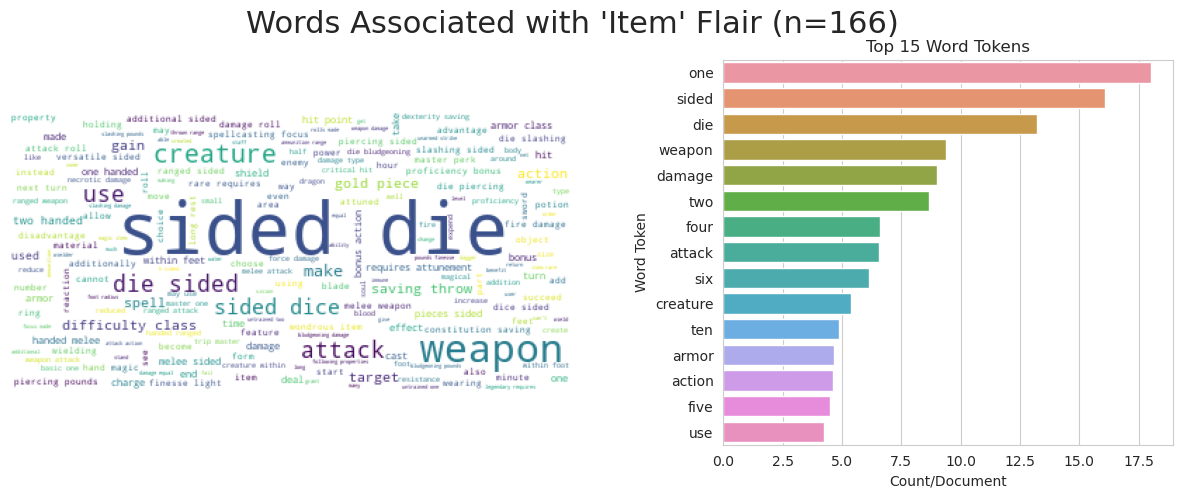

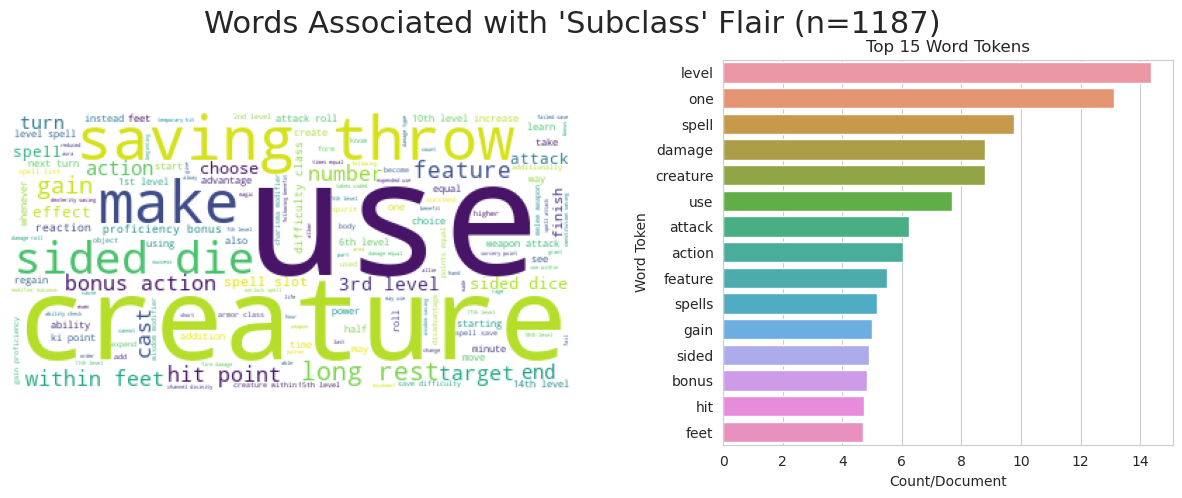

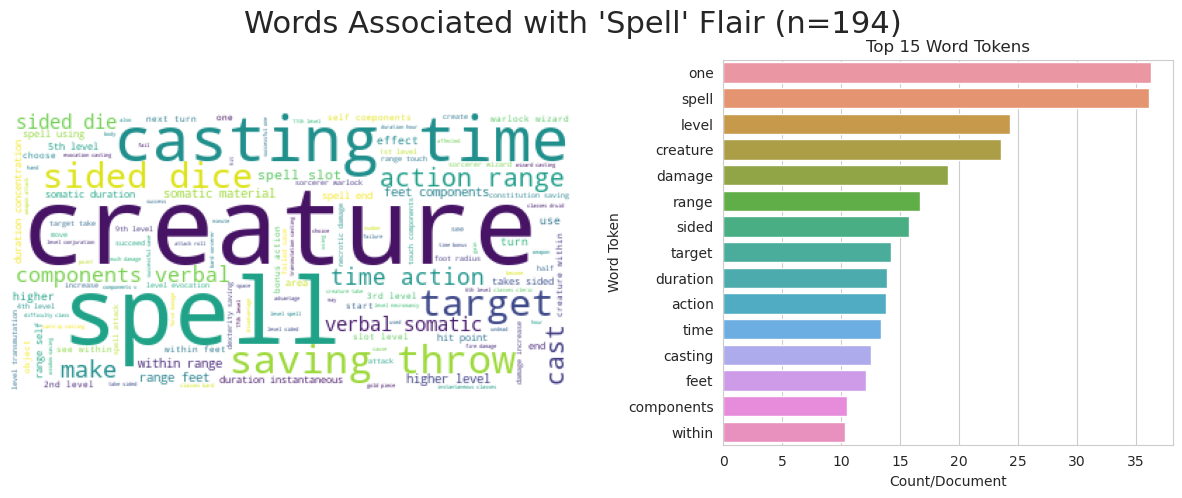

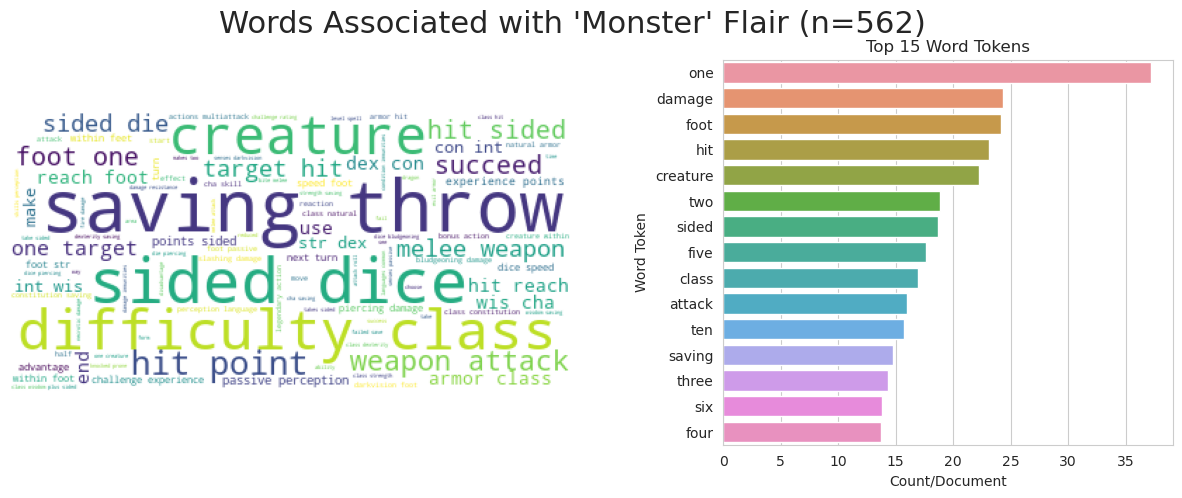

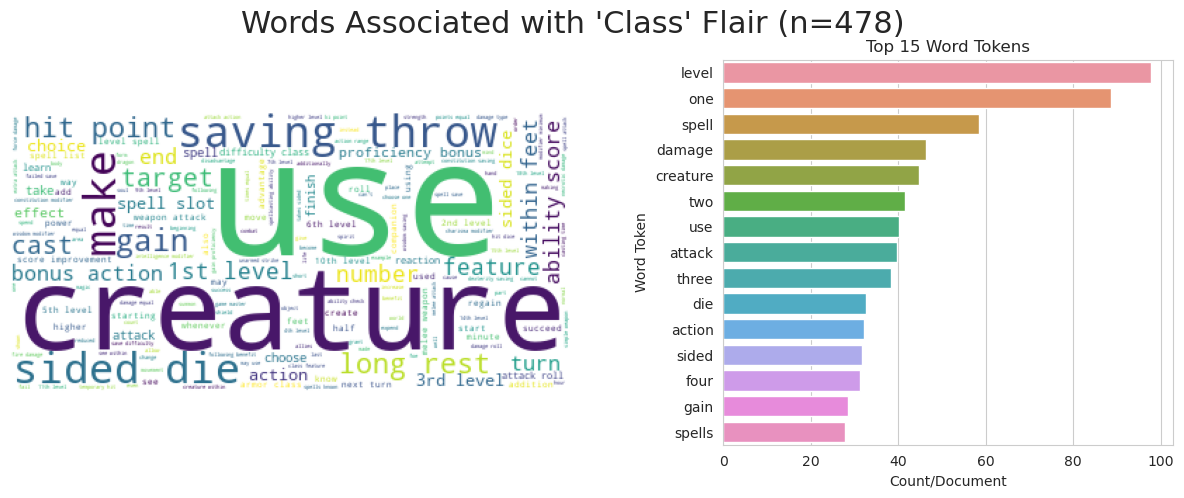

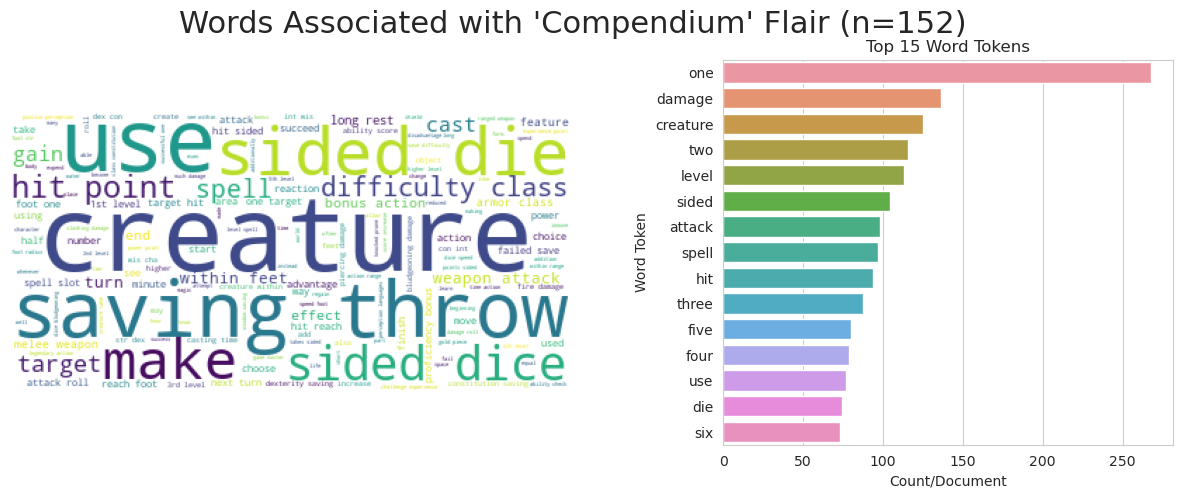

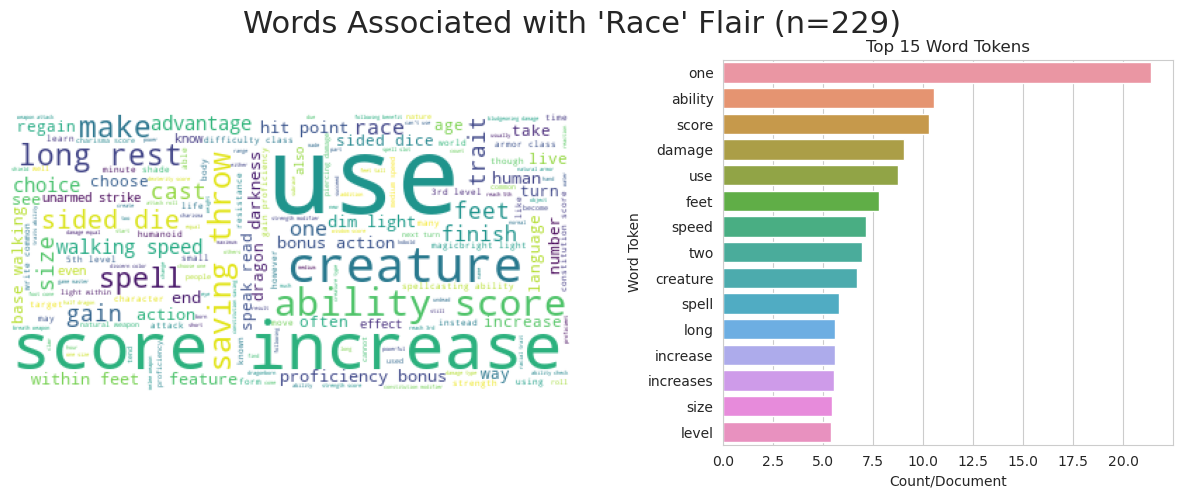

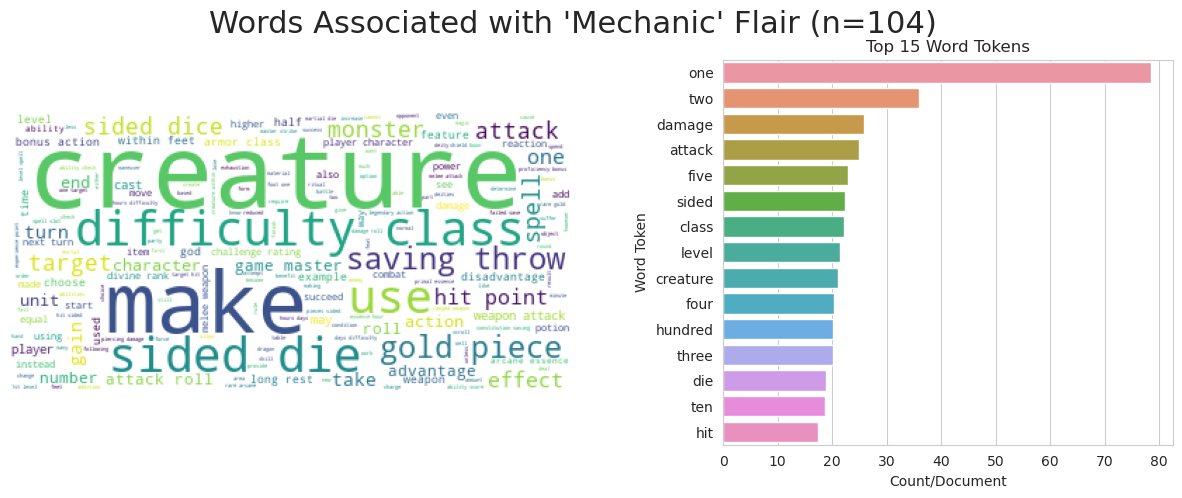

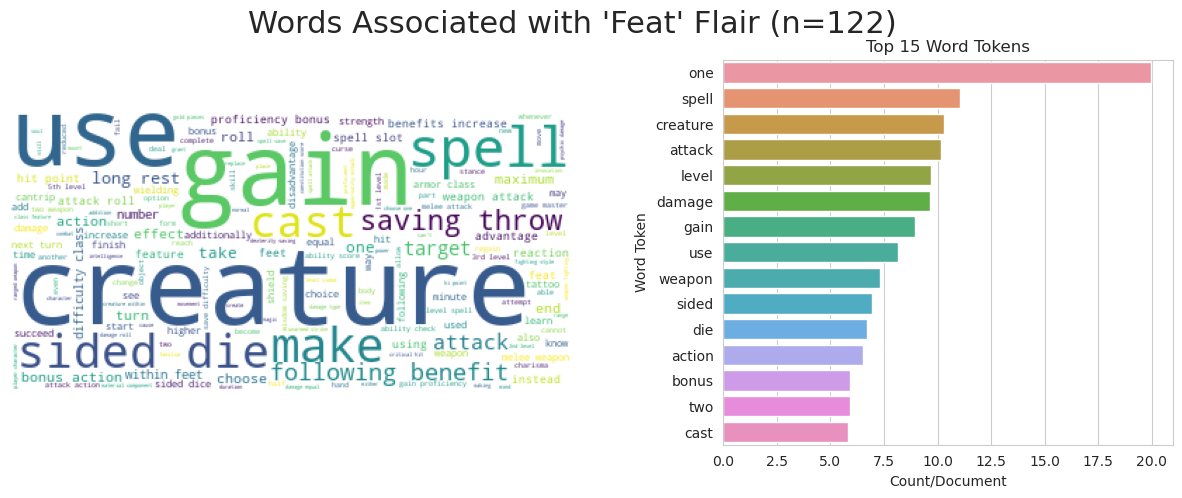

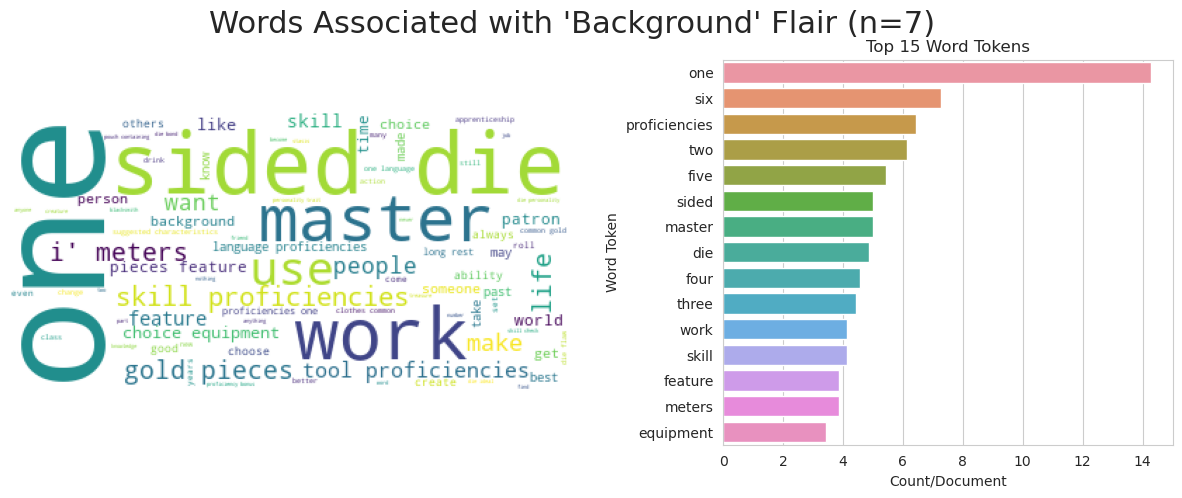

In [4]:
TOP_N_WORDS = 15
STOP_WORDS = stopwords.words("english")
for flair in doc_df["submission_flair"].unique():
    # Subset data
    documents = doc_df[doc_df["submission_flair"] == flair]
    plot_top_words(
        documents=documents,
        label=flair,
        word_token_col="clean_word_tokens",
        text_col="clean_text",
        stop_words=STOP_WORDS,
        n_words=TOP_N_WORDS,
        save_path=CLOUD_DIR,
    )

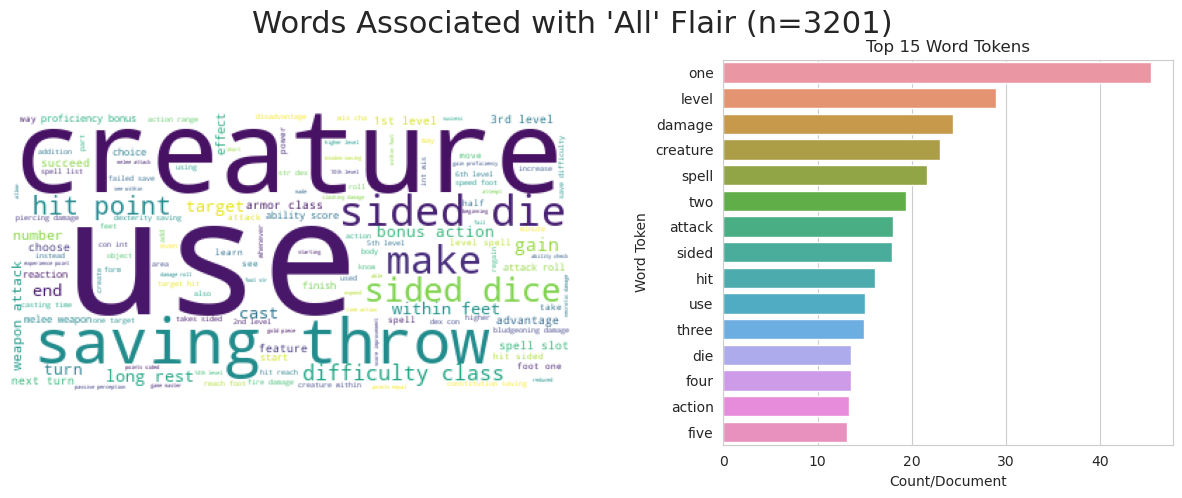

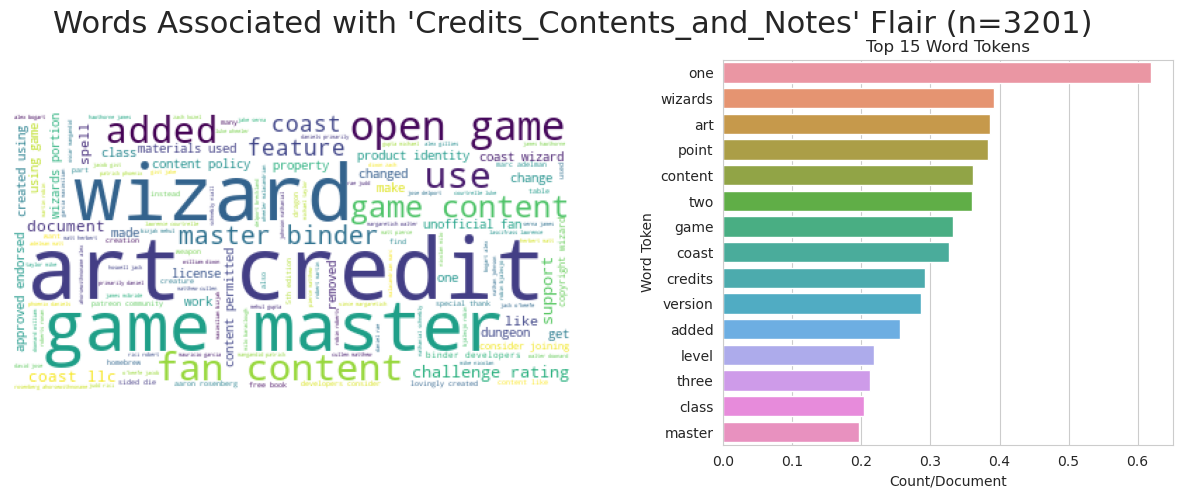

In [5]:
plot_top_words(
    documents=doc_df,
    label="All",
    word_token_col="clean_word_tokens",
    text_col="clean_text",
    stop_words=STOP_WORDS,
    n_words=TOP_N_WORDS,
    save_path=CLOUD_DIR,
)

plot_top_words(
    documents=doc_df,
    label="Credits_Contents_and_Notes",
    word_token_col="credit_word_tokens",
    text_col="credit_text",
    stop_words=STOP_WORDS,
    n_words=TOP_N_WORDS,
    save_path=CLOUD_DIR,
)

### Count Vectorization
For the next few task it will help to use count vectors.

#### Faux Tokenization
Note, since we pre-computed tokens in the previous notebook, we need a dummy tokenizer to pass to scikit-learn's vectorizer classes. In this case, I've called the function do_nothing (although it technically does tokenize strings, since sklearn passes the stop words to the tokenizer)

In [6]:
with open(OBJ_DIR / "tokenizer.pkl", "rb") as p:
    ea_tokenizer: EmbeddingAwareTokenizer = pkl.load(p)

STOP_WORDS = stopwords.words("english")
STOP_WORDS = [ea_tokenizer.tokenize(sw) for sw in STOP_WORDS]
STOP_WORDS = [token for sw_tokens in STOP_WORDS for token in sw_tokens]


def do_nothing(tokens: List[str], tokenizer: EmbeddingAwareTokenizer = ea_tokenizer):
    """
    Return pre-determined tokens to sklearn count vectorizer
    If this is a string (i.e. for stopwords), return the string as a list

    Parameters
    ----------
    tokens : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    if isinstance(tokens, str):
        return [tokens]
    else:
        return tokens


vectorizer = CountVectorizer(
    tokenizer=do_nothing, lowercase=False, token_pattern=None, stop_words=STOP_WORDS
)
count_vectors = vectorizer.fit_transform(doc_df["clean_word_tokens"])
count_vectors.shape

(3201, 45915)

In [8]:
count_metadata = pd.DataFrame(index=vectorizer.get_feature_names_out())
count_metadata["total_counts"] = count_vectors.toarray().sum(axis=0)
count_metadata["total_docs"] = (count_vectors.toarray() > 0).sum(axis=0)

# Dimension Reduction/Plotting Labels
Next, I'll take a look at how well the flair/labels separate just among the first few principal components in order to get an idea of how linear/non-linear the boundaries between labels are.

For this, I'll be making use of a similar tokenization scheme as above and the TfidVectorizer (Term Frequency - Inverse Document Frequency) from sklearn, which produces a measure of how frequently each word occurs within a given text relative to the whole text.

Here I'm working with the full dataset for illustrative purposes, but if/when I feed these to a classifier for training purposes I'll be using only the training examples to learn the loadings for PCA.

In [9]:
def get_and_plot_pcs(X: np.ndarray, df: pd.DataFrame, pref: str = "") -> np.ndarray:
    pca = PCA(n_components=50)
    pcs = pca.fit_transform(X)
    print(
        f"{pcs.shape[0]} principal components calculated, accounting for {pca.explained_variance_.sum()} of total variance."
    )

    _df = df[["submission_flair"]].copy()
    for i in range(6):
        _df[f"{pref}PC{i+1}"] = pcs[:, 0 + i]

    spaced_pref = pref.replace("_", " ")
    subtitle = f"\n({spaced_pref})" if pref != "" else ""
    # Scree plot
    pc_vals = np.arange(pca.n_components_) + 1
    plt.plot(pc_vals, pca.explained_variance_ratio_, "o-", linewidth=2, color="blue")
    plt.title(f"Scree Plot{subtitle}")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained")
    plt.savefig(DR_DIR / f"{pref}Doc_EDA_DIR_PCA_Scree.pdf")
    plt.show()

    for p in [(1, 2), (3, 4), (5, 6)]:
        sns.scatterplot(
            data=_df, x=f"{pref}PC{p[0]}", y=f"{pref}PC{p[1]}", hue="submission_flair"
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        plt.title(f"Document Submission Flair in Reduced Dimensions{subtitle}")
        plt.tight_layout()
        plt.savefig(DR_DIR / f"{pref}Doc_EDA_DIR_Flair_PC{p[0]}_PC{p[1]}.pdf")
        plt.show()
        plt.close()

    return pcs

In [10]:
def get_and_plot_umap(
    pcs: np.ndarray,
    df: pd.DataFrame,
    hue_cols: List[str],
    pref: str = "",
    n_pcs: Optional[int] = None,
):
    if n_pcs == None:
        n_pcs = pcs.shape[1]

    pcs = pcs[:, 0:n_pcs]

    # Fixed UMAP settings for now since this is just a quick visualization
    umap_model = umap.UMAP(
        n_neighbors=50,
        min_dist=0.8,
        n_components=2,
        metric="euclidean",
        random_state=239859283,
    )
    umap_vals = umap_model.fit_transform(pcs[:, 0:n_pcs])

    cols = [
        "submission_flair",
        "manually_reviewed",
        "num_sections",
        "log2_num_sections",
    ]
    _df = df[cols].copy()

    spaced_pref = pref.replace("_", " ")

    _df[f"{pref}UMAP1"] = umap_vals[:, 0]
    _df[f"{pref}UMAP2"] = umap_vals[:, 1]

    for h in hue_cols:
        sns.scatterplot(data=_df, x=f"{pref}UMAP1", y=f"{pref}UMAP2", hue=h)
        h_words = h.split("_")
        spaced_h = " ".join([i.capitalize() for i in h_words if i != ""])
        cap_h = "_".join([i.capitalize() for i in h.split("_")])

        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
        subtitle = f"\n({spaced_pref})" if pref != "" else ""
        plt.title(f"Document {spaced_h} (UMAP){subtitle}")
        plt.tight_layout()
        plt.savefig(DR_DIR / f"{pref}Doc_EDA_DIR_{cap_h}_UMAP.pdf")
        plt.show()
        plt.close()

    return umap_vals

## Dimension Reduction & Visualization

Since this is just to get a basic sence of how complex the data might be, I'm not going to perform substantial amounts of optimization or feature selection here. We'll go with some common choices to visualize the data in 2-dimensional plots.

We now have an `n_obs x n_unique_tokens` matrix representing TF-IDF transformed count vectors.

Next, I'll get the first N principal components that explain 90% of the variance in the dataset, it's more common to go with 95-100%, but some initial guess and check demonstrated that it takes a lot of PCs to capture much of the variance and I want things to be kept light for now. We'll visualize the first few pairs of PCs in order and then pass the PCs representing 90% of the variance to a more sophisticated dimension reduction technique that allows for greater non-linearity (UMAP).

### Raw Counts
Commonly people will apply transformations such as TF-IDF to bag-of-words data, but I have a supscion that this will actually remove important information (the length) that clearly delineates a lot of classes quite well.

So I'll first apply PCA/UMAP reduction using the raw word counts.

#### Poor separation by PCs alone for raw counts
Overall the first few PCs capture a lot of variation (PC1 in particular), but the classes don't seem to separate along any individual PCs very well (this does not mean that their combinations won't)

3201 principal components calculated, accounting for 1679245.9496659068 of total variance.


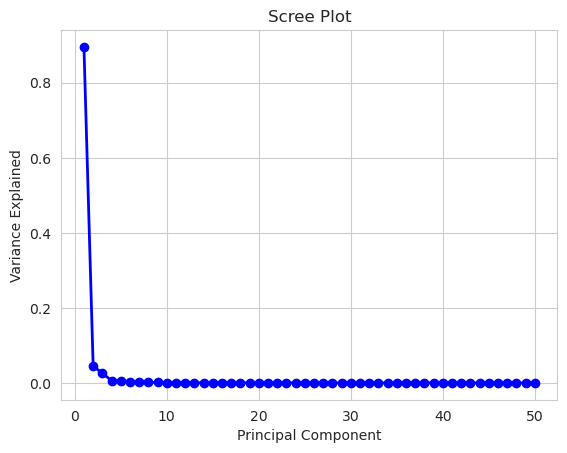

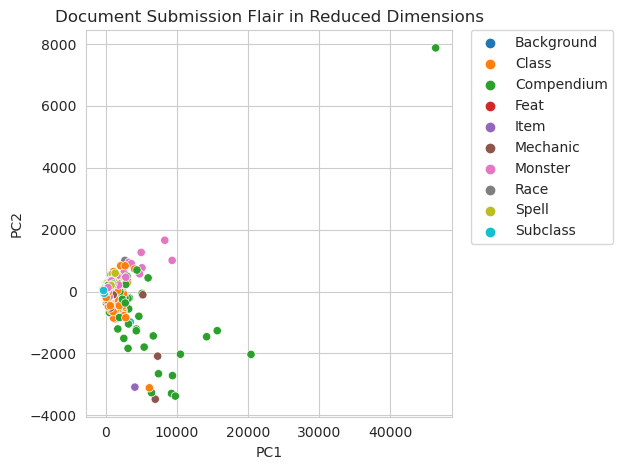

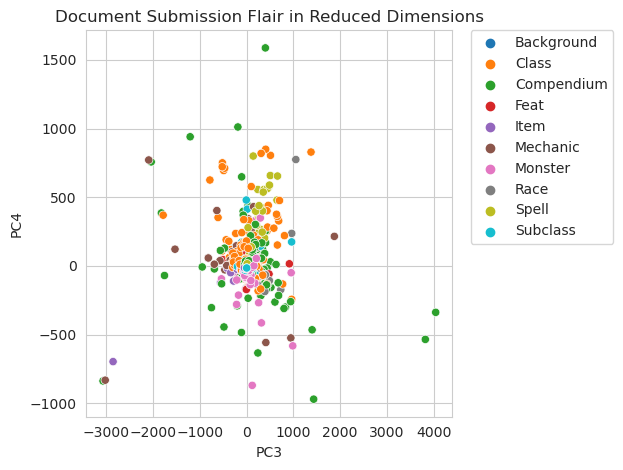

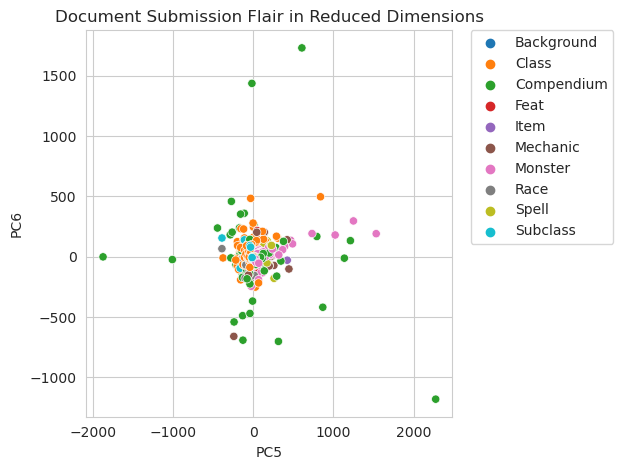

In [11]:
pcs = get_and_plot_pcs(count_vectors.toarray(), doc_df, "")

#### Raw counts give very good separation along UMAP embeddings
In contrast, feeding the first 30 PCs to UMAP gives very impressive separation

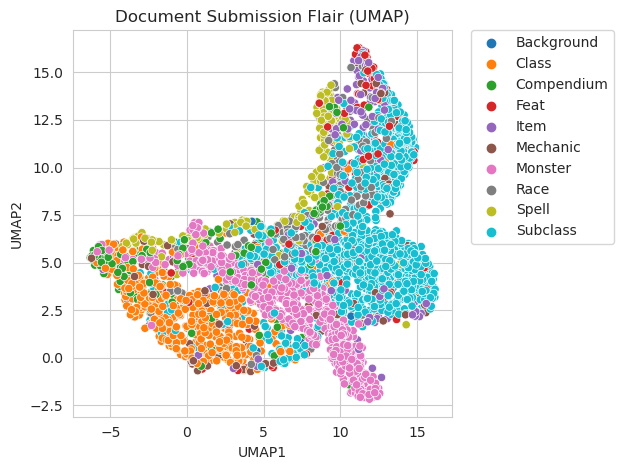

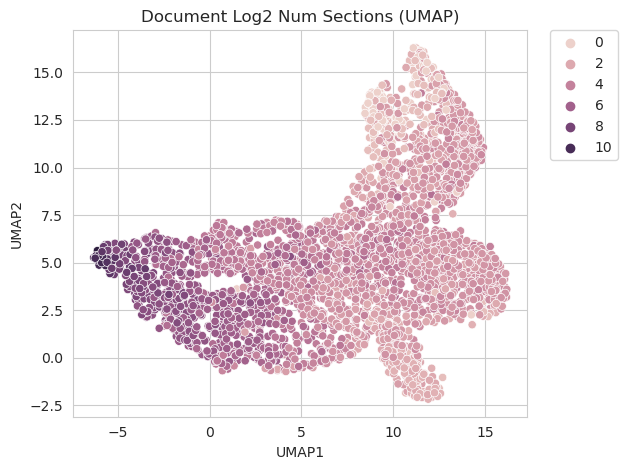

In [12]:
doc_df["log2_num_sections"] = np.log2(doc_df["num_sections"])
umaps = get_and_plot_umap(
    pcs=pcs,
    df=doc_df,
    pref="",
    n_pcs=30,
    hue_cols=["submission_flair", "log2_num_sections"],
)

### TF-IDF
Next I'll apply the commonly used TF-IDF transformation.

In [13]:
tfidf_vectors = TfidfTransformer().fit_transform(count_vectors)
del count_vectors

3201 principal components calculated, accounting for 0.21589638805257824 of total variance.


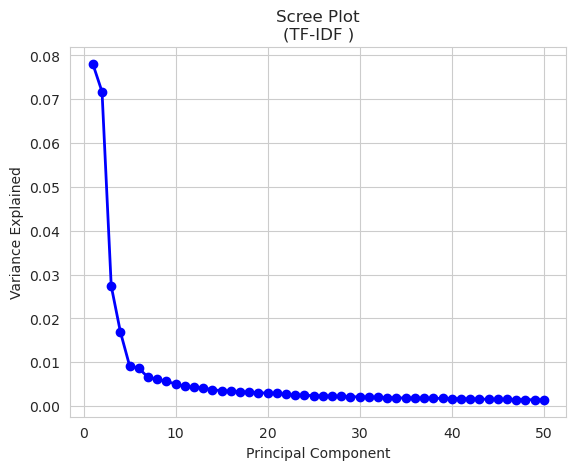

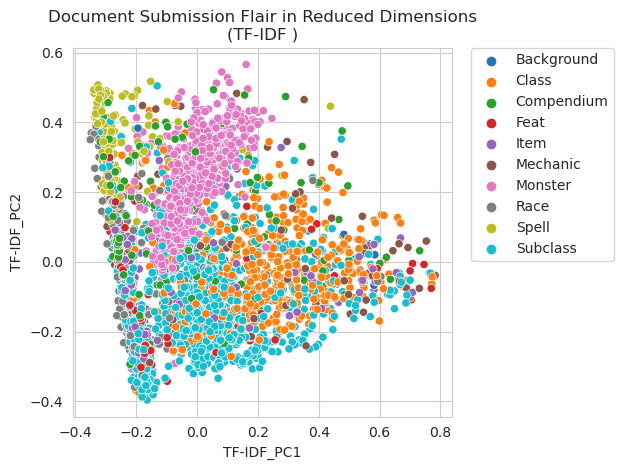

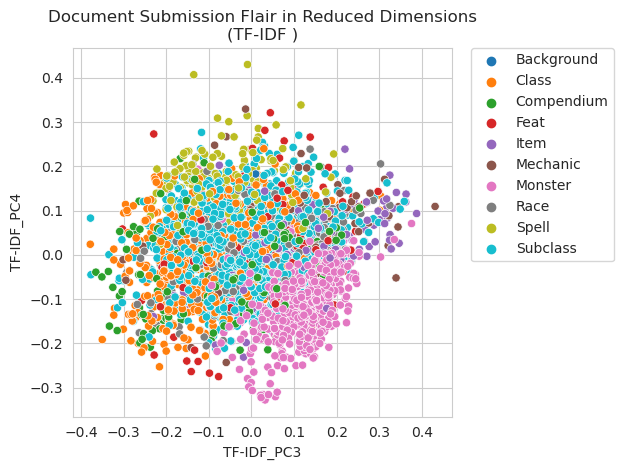

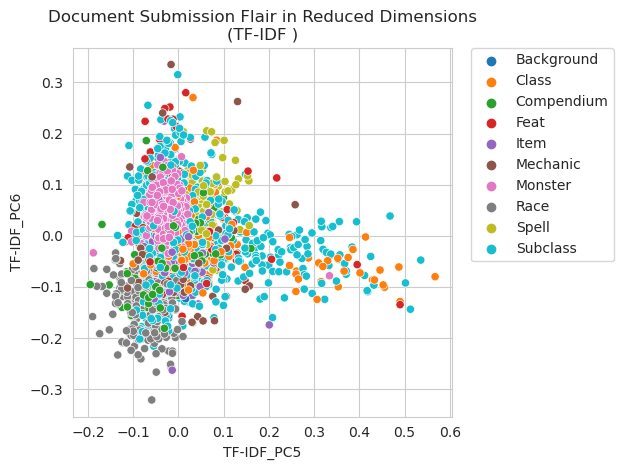

In [14]:
pcs = get_and_plot_pcs(tfidf_vectors.toarray(), doc_df, "TF-IDF_")

#### Several flair separate nicely along just the first few PCS
As you can see above, the first few PCs already begin to separate the flair one-vs-one nicely along nearly-linear boundaries. This means we can probably achieve decent performance with a small number of principal components using fairly friendly algorithms (i.e. decision trees, SVM, etc) that allow for a small amount of non-linearity and are quick to train.

Noteably, a few flair (e.g. compendiums and feats) are trickier. My intuition/guess is that compendiums will separate best if we include a feature which encodes the total length of each piece of content as well, since compendiums are collections of multiple pieces of individual content belonging to one or more flair categories. Feats on the other hand, blend in with classes/subclasses quite a bit. This is probably in part because classes and subclasses can be thought of as a set of related feats. Length will probably also help here, but this raises another important point to consider for later...

Eventually I will want to perform segmented, multi-class labeling and correctly recognize this level of nuance within the texts (i.e. that some flair have instances where they are composed of other flair that are currently treated as mutually-exclusive, i.e classes and subclasses are made up of features and can even grant spells or monsters companions, etc).


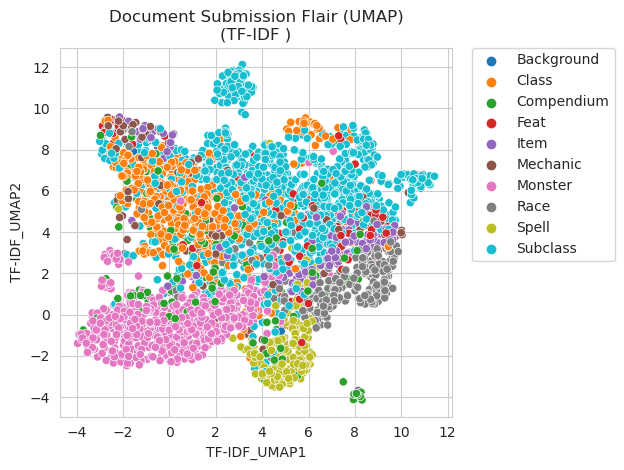

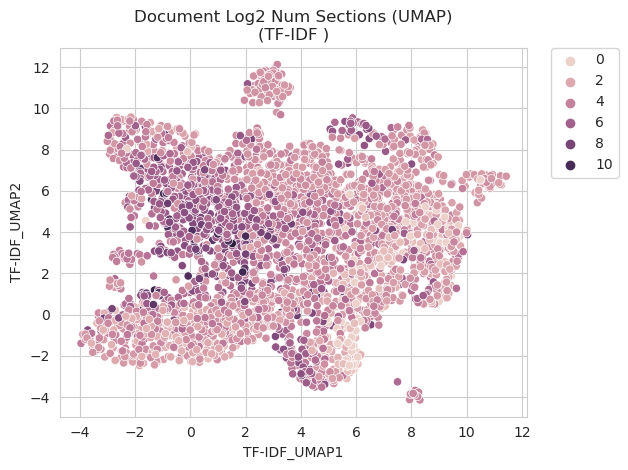

In [15]:
umaps = get_and_plot_umap(
    pcs=pcs,
    df=doc_df,
    pref="TF-IDF_",
    n_pcs=30,
    hue_cols=["submission_flair", "log2_num_sections"],
)

### TF-IDF with Total # Words

In [16]:
length_scaler = StandardScaler()
doc_df["scaled_word_count"] = length_scaler.fit_transform(
    doc_df["clean_word_tokens"].map(len).values.reshape(-1, 1)
)

In [17]:
tfidf_vectors_with_len = np.hstack(
    (
        tfidf_vectors.toarray(),
        doc_df["scaled_word_count"].values[:, np.newaxis],
    )
)

3201 principal components calculated, accounting for 1.2153496003577389 of total variance.


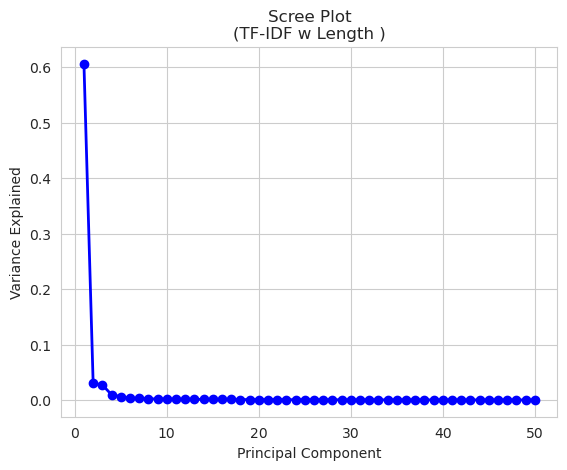

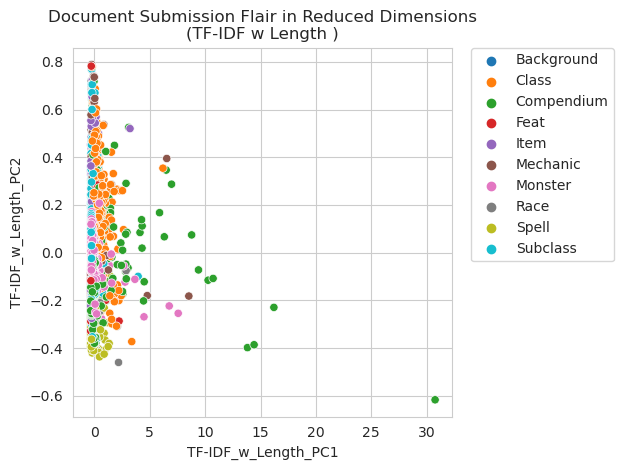

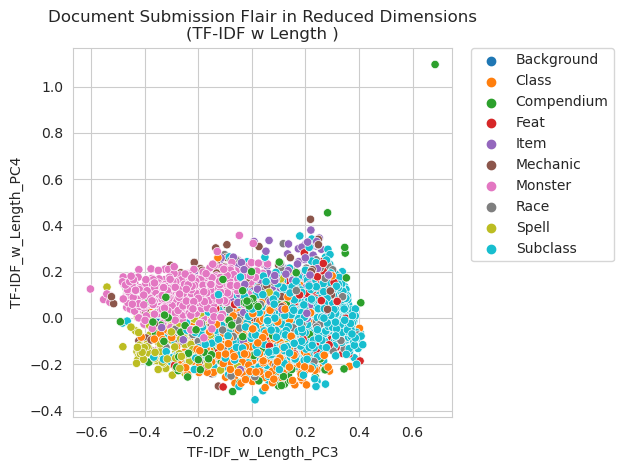

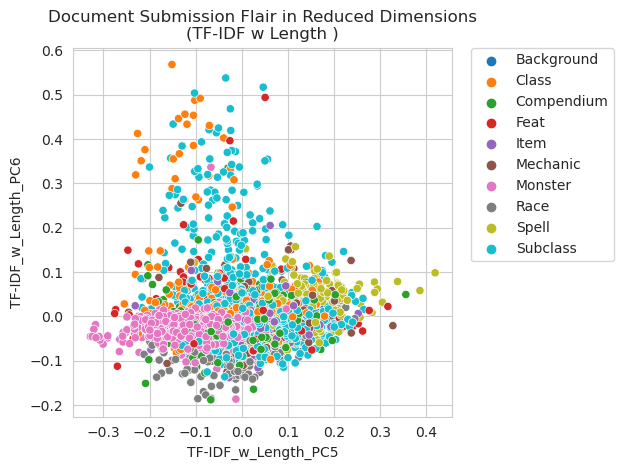

In [18]:
pcs = get_and_plot_pcs(tfidf_vectors_with_len, doc_df, "TF-IDF_with_Length_")

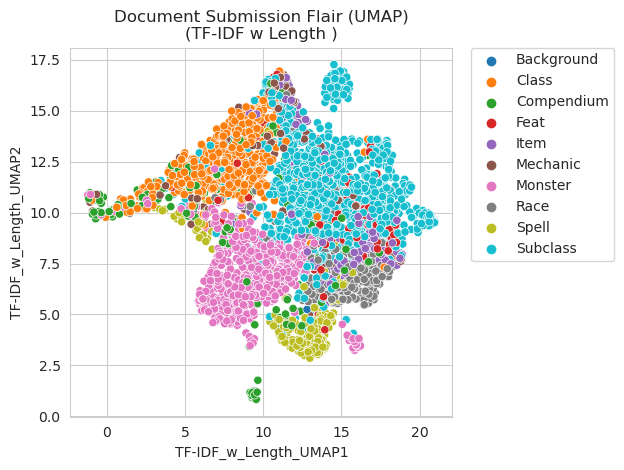

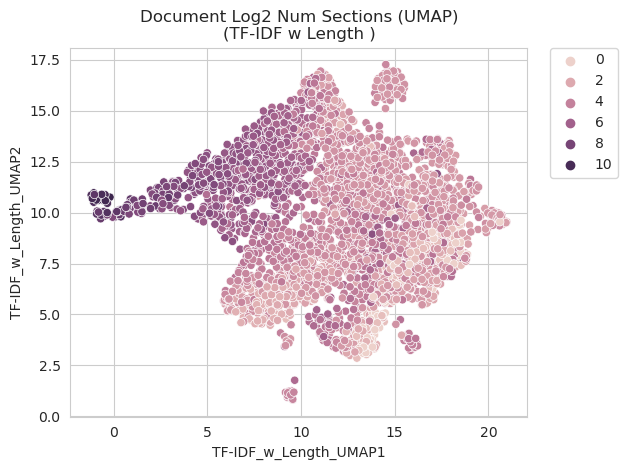

In [19]:
umaps = get_and_plot_umap(
    pcs=pcs,
    df=doc_df,
    pref="TF-IDF_w_Length_",
    n_pcs=30,
    hue_cols=["submission_flair", "log2_num_sections"],
)